In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Prediction of Unhealthy Air Pollutant Levels In Order To Better Manage Patient Care

## *Molly McNamara*




## Introduction

High air pollution levels have been consistently documented as a major environmental risk to health. The World Health Organization has stated that the majority of the world’s population is living in areas that do not meet air quality guidelines and estimated that outdoor air pollution caused 3 million premature deaths in 2012. While programs do exist in many countries to combat air pollution with the aim of reducing levels of harmful pollutants, weather patterns and geographical features can also influence the concentration of air pollutants in many areas. Among other things, exposure to air pollutants can cause the development of respiratory diseases and exacerbate existing cases. Not only is air pollution a documented health risk, it is associated with an increased utilization of health care services ([Environmental Health 2011](https://ehjournal.biomedcentral.com/articles/10.1186/1476-069X-10-71), [Epidemiology 2004](journals.lww.com/epidem/Abstract/2004/01000/Ambient_Air_Pollution_and_Cardiovascular_Emergency.9.aspx), [American Journal of Epidemiology 2001](https://academic.oup.com/aje/article/153/5/444/149769), [Epidemiology 2005](journals.lww.com/epidem/Abstract/2005/03000/Ambient_Air_Pollution_and_Respiratory_Emergency.4.aspx)). 

Given the health risks involved in elevated levels of air pollutants, it would be useful for health care providers and hospitals to predict the uptick of services during periods of poor air quality. Prediction of periods of increased patient illness could help with planning for hospital staffing needs as well as preventative care and messaging to reduce hospital visits. Staffing in particular is a challenge hospitals face, due to an anticipated shortfall in registered nurses. By 2025, researchers expect a shortage “more than twice as large as any nurse shortage experienced since the introduction of Medicare and Medicaid in the mid-1960s" ([Health Affairs, 2009](https://www.healthaffairs.org/doi/abs/10.1377/hlthaff.28.4.w657)). Given the challenges facing the health care system in the United States, there is a tremendous financial incentive to better manage high risk patients.

The hypothetical client in this case is Kaiser Permanente, a large managed care organization that runs a number of hospitals and clinics with an emphasis on preventive care and population health management. Prediction of air quality incidents that may affect population health and cause a spike in emergency room visits and hospitalizations may help Kaiser staff their clinics accordingly and in advance rather than face nursing shortages that could impact quality of care, wait times or their quality metrics.


## The Data

Multiple datasets were combined for this analysis.  The primary dataset consists of daily levels of 4 primary air pollutants (Nitrogen Dioxide, Sulphur Dioxide, Carbon Monoxide and Ozone) and their Air Quality Index values from major cities across the United States between 2000 and 2016. The data is sourced from the United States Environmental Protection Agency and downloaded from [a compiled set at Kaggle](https://www.kaggle.com/sogun3/uspollution/data) as a CSV file.

Air Quality Index values equate to health concerns as follows, per the Environmental Protection Agency:
* 0 to 50 Good
* 51 to 100 Moderate
* 101 to 150 Unhealthy for Sensitive Groups
* 151 to 200 Unhealthy
* 201 to 300 Very Unhealthy
* 301 to 500 Hazardous

Additional data was compiled from climate data collected by the [National Oceanic and Atmospheric Administration](https://www.ncdc.noaa.gov/cdo-web/search) (NOAA) for 7 of the largest US cities in the pollution dataset from January 1, 2000 through December 31, 2015. The variables include elevation of the city, daily precipitation, air pressure, wind speed and the daily high and low temperatures.  This information was ordered from the NOAA website, downloaded as multiple CSV files, in ~ 5-year blocks by city, and then appended to one another.


## Data Wrangling

___
### Pollution

The pollution dataset was imported into iPython notebook and determined to consist of 1,746,661 observations with 28 columns. Further evaluation revealed that there were multiple duplicate/triplicate observations for many days at the same collection site. When this duplicate data was removed (by grouping by date and site and then retaining the mean value for each variable), the dataset consisted of one row for each date for each site, for a total of 412,856 rows.

Columns that would not be used in analysis were dropped; specifically the columns for state and city code, address of testing site, and units of measure for pollutant levels were removed. The column for local date was converted to a datetime object. The dataset was evaluated for null/empty fields and these were replaced using fillna.

Boxplots were generated to evaluate the spread of each pollutant's Air Quality Index by state. Finally, the columns of the dataset were renamed to make them easier to work with going forward. A clean CSV file was saved.


___
### Weather

The weather datasets were imported into iPython notebook and appended to one another.  The final dataset was determined to consist of 1,247,655 observations with 90 columns. Hourly and monthly data columns were dropped so that the weather dataset would contain daily data to match the pollution dataset.  Null values were handled using the ffill function.  

The dataset was filtered to retain only the last daily timepjoint at 11:59pm, which captured the daily averages based on the data from the entire day.  The column for local date was converted to a datetime object.

The columns of the dataset were renamed to make them easier to work with going forward and to match the nomenclature of date and city in the pollution dataframe. Finally, the pollution and weather dataframes were merged on a left join by City and Date. A clean CSV file was saved.


## Exploratory Data Analysis and Statistical Findings

The pollution data comes from 141 cities in 46 US states (plus 3 cities in Mexico).

As seen in Figure 1, the four pollutants’ Air Quality Index measured range from Good to Very Unhealthy. On average, based on the mean, they tend to be in the Good rating and so being able to predict those excursions into unsafe levels is the goal of this analysis.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from ggplot import *

pd.set_option("display.max.columns",500)
%matplotlib inline
pollution = pd.read_csv('~/Desktop/pollutionnew.csv', index_col='Unnamed: 0')
pollution['Date_Local']= pd.to_datetime(pollution['Date_Local'],  errors='raise', format='%Y/%m/%d')

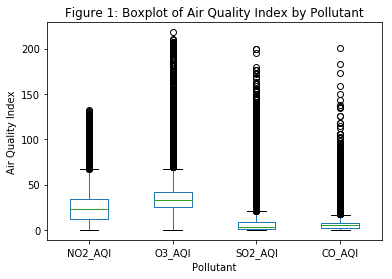

In [3]:
AQI = ['NO2_AQI', 'O3_AQI', 'SO2_AQI', 'CO_AQI']
pollution[AQI].plot(kind='box')
plt.xlabel('Pollutant')
plt.ylabel('Air Quality Index')
plt.title('Figure 1: Boxplot of Air Quality Index by Pollutant')
plt.show()

Pollutant levels were further assessed visually for the 10 largest cities in the United States (by census data) to compare the distributions (Figures 2-5) and confirmed that each city has a unique profile. 

In [4]:
top10cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix', 'Philadelphia', 'San Antonio', 'San Diego', 'Dallas', 'San Jose']
top10 = pollution[pollution['City'].isin(top10cities)]

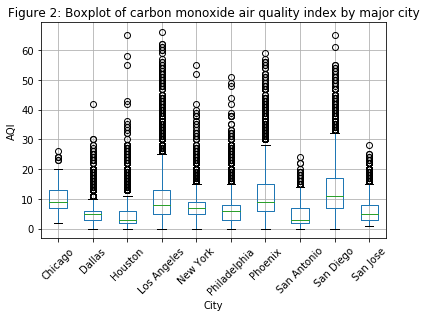

In [5]:
top10.boxplot(column='CO_AQI', by='City', rot=45)
plt.xlabel('City')
plt.ylabel('AQI')
plt.suptitle("")
plt.title('Figure 2: Boxplot of carbon monoxide air quality index by major city')
plt.show()

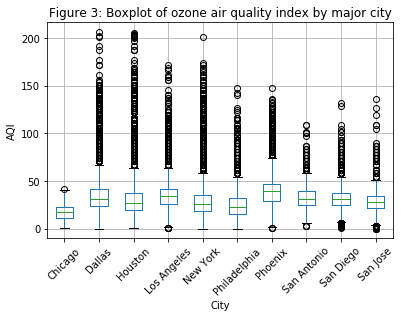

In [6]:
top10.boxplot(column='O3_AQI', by='City', rot=45)
plt.xlabel('City')
plt.ylabel('AQI')
plt.suptitle("")
plt.title('Figure 3: Boxplot of ozone air quality index by major city')
plt.show()

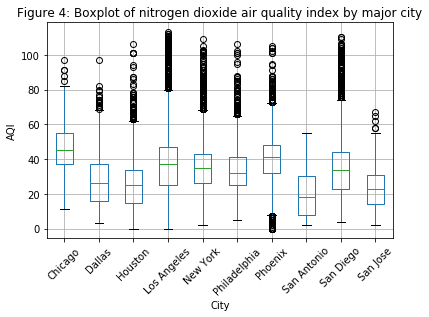

In [7]:
top10.boxplot(column='NO2_AQI', by='City', rot=45)
plt.xlabel('City')
plt.ylabel('AQI')
plt.suptitle("")
plt.title('Figure 4: Boxplot of nitrogen dioxide air quality index by major city')
plt.show()

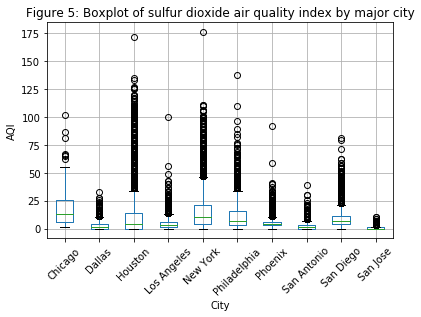

In [8]:
top10.boxplot(column='SO2_AQI', by='City', rot=45)
plt.xlabel('City')
plt.ylabel('AQI')
plt.suptitle("")
plt.title('Figure 5: Boxplot of sulfur dioxide air quality index by major city')
plt.show()

Pollutant fluctuations were also evaluated over time and demonstrated seasonal/annual variability (Figures 6-9) for the largest 5 US cities (this number was reduced from 10 to improve visual clarity of the trends).

In [9]:
top5cities = ['New York', 'Los Angeles', 'Chicago', 'Houston', 'Phoenix']
top5 = pollution[pollution['City'].isin(top5cities)]

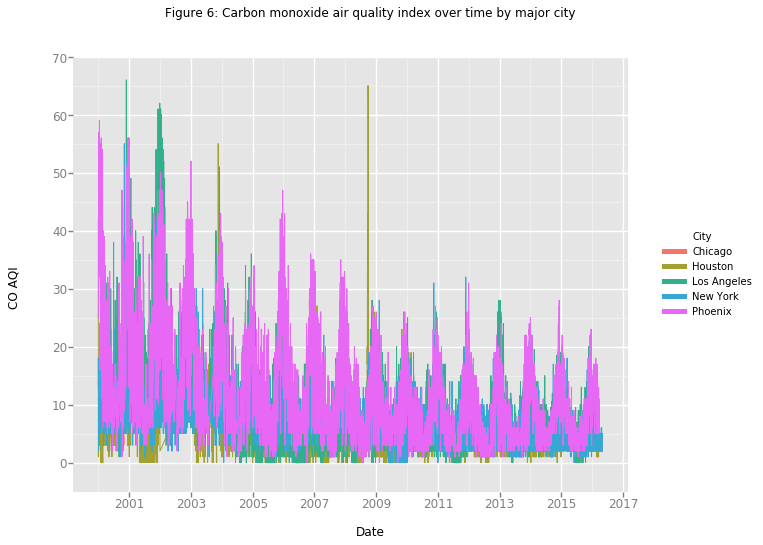

<ggplot: (291386951)>

In [10]:
ggplot(top5, aes(x='Date_Local', y='CO_AQI', color='City')) + geom_line() + scale_y_continuous(limits = (-5, 70)) + ggtitle("Figure 6: Carbon monoxide air quality index over time by major city") + xlab("Date") + ylab("CO AQI")

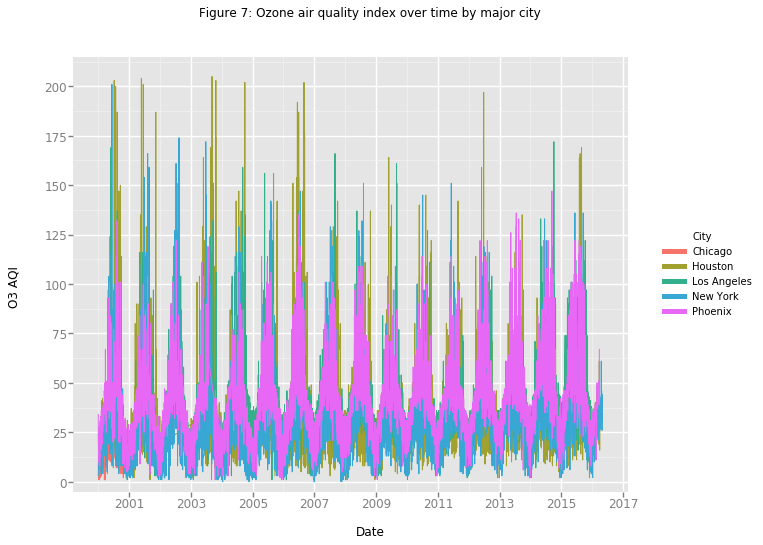

<ggplot: (-9223372036563388896)>

In [11]:
ggplot(top5, aes(x='Date_Local', y='O3_AQI', color='City')) + geom_line() + scale_y_continuous(limits = (-5, 215)) + ggtitle("Figure 7: Ozone air quality index over time by major city") + xlab("Date") + ylab("O3 AQI")

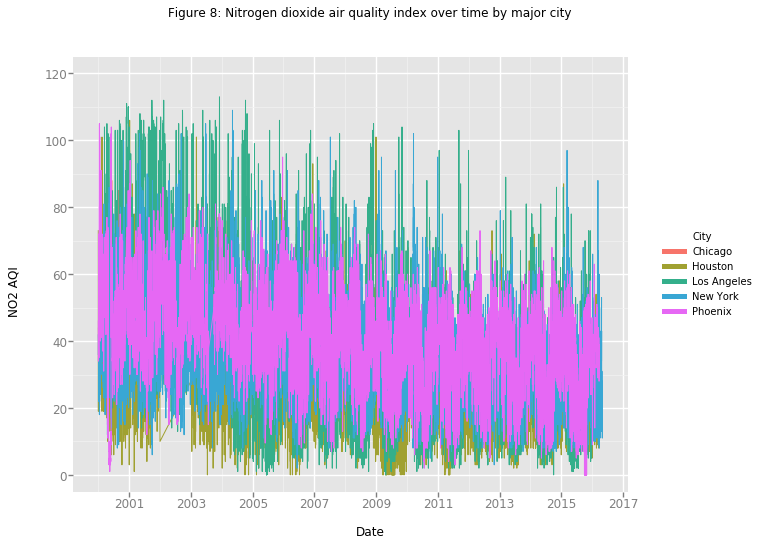

<ggplot: (290514415)>

In [12]:
ggplot(top5, aes(x='Date_Local', y='NO2_AQI', color='City')) + geom_line() + scale_y_continuous(limits = (-5, 125)) + ggtitle("Figure 8: Nitrogen dioxide air quality index over time by major city") + xlab("Date") + ylab("NO2 AQI")

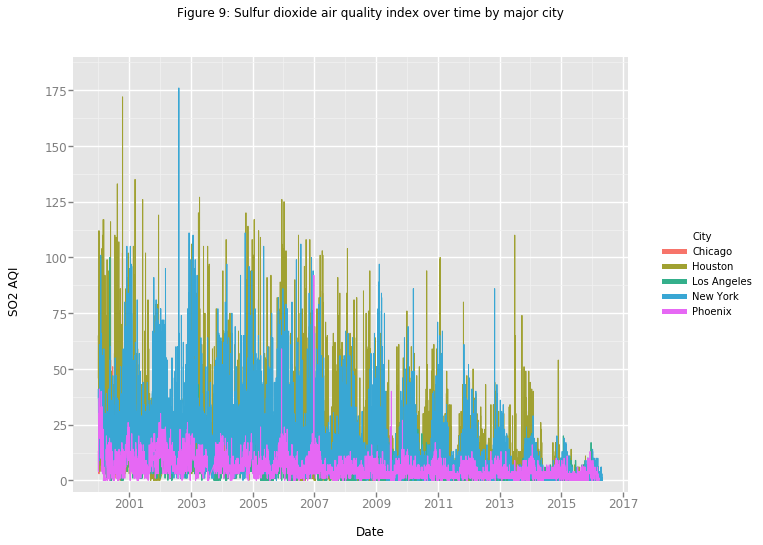

<ggplot: (-9223372036564317878)>

In [13]:
ggplot(top5, aes(x='Date_Local', y='SO2_AQI', color='City')) + geom_line() + scale_y_continuous(limits = (-5, 190)) + ggtitle("Figure 9: Sulfur dioxide air quality index over time by major city") + xlab("Date") + ylab("SO2 AQI")

The pollutant Air Quality Index values did not appear to be normally distributed (though mean daily ozone levels are). This may be a function of many values close to 0 or some sort of natural limit. 

The pollutant levels were assessed relative to the historical weather data to identify any correlations.  There were relatively strong correlations present between pollutant levels and weather features such as average and maximum temperature and average sea level pressure.  Figure 10 demonstrates an example of the correlative relationship between maximum temperature and Ozone Air Quality Index for the city of Phoenix.

In [ ]:
import seaborn as sns
import numpy as np
pollutionw = pd.read_csv('~/Desktop/weatherpollution.csv', index_col='Unnamed: 0')
pollutionw['Date_Local']= pd.to_datetime(pollutionw['Date_Local'],  errors='raise', format='%Y/%m/%d')
the7cities = ['New York', 'Los Angeles', 'Houston', 'Phoenix', 'Philadelphia', 'San Diego', 'Dallas']
pollution7 = pollutionw[pollutionw['City'].isin(the7cities)]

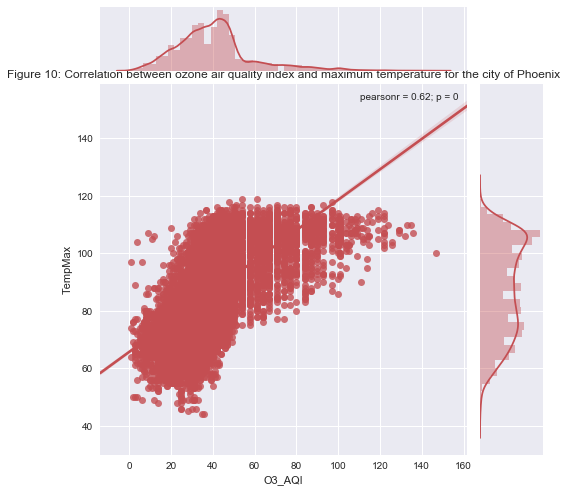

In [19]:
sns.set(style="darkgrid", color_codes=True)
sns.jointplot('O3_AQI', 'TempMax', data=pollution7[pollution7['City'] == 'Phoenix'],
              kind='reg', color='r', size=7)
sns.plt.title('Figure 10: Correlation between ozone air quality index and maximum temperature for the city of Phoenix')
plt.show()

## Predictive Modeling

The data for 7 of the largest 10 cities in the US was used to develop the predictive model; this subset consisted of 15 years of data (January 1, 2000 through December 31, 2015) with both pollution and weather components.  These cities were New York, Los Angeles, Houston, Phoenix, Philadelphia, San Diego, and Dallas. This constitutes a dataset of 56,073 observations with 27 columns.  Categorical variables were created to translate Air Quality Index values into categories (Good, Moderate, Unhealthy, etc).  


___
### Initial Modeling

For each pollutant, a logistic regression model was built to predict Air Quality Index outcome based on a set of features (Average Temperature, Maximum Temperature, Minimum Temperature, Elevation, Average Relative Humidity, Average Dew Point Temperature, Sunrise, Sunset, Average Station Pressure, Average Sea Level Pressure, and Sustained Wind Speed).  A train-test split of 80% train/20% test was used.

The initial round of regression analysis resulted in models with relatively high accuracies; however upon further evaluation of the confusion matrices, the models were extremely poor at discriminating the less populated classes.  

Logistic regression was repeated with cross-validation and balanced class weighting.  The accuracy of the cross validated models was lower but perhaps slightly better in terms of predicting the classes. The imbalance between the classes was still an issue.

___
### Modeling Improvements

To begin with, all of the feature data was normalized to ensure consistent input.  Then the Air Quality Index values were recategorized into less categories (Good versus Elevated) to attempt to better power the smaller classes.

Even with this recombination of pollutant categories, the dataset was simply underpowered with regard to elevated Carbon Monoxide levels. In over 55,000 observations, there were not enough to sufficiently power a predictive model. The analysis going forward focused on pollutants with a larger number of high levels observed.

Using the normalized feature data and new outcome categories, logistic regression with cross-validation and balanced class weighting was repeated and yielded improved results.  While some accuracy was lost in each model, the prediction of Elevated pollutant levels was substantially better.  ROC curves and AUC were also assessed for each model. 


#### Table 1: Improved Model Metrics

| Pollutant | Accuracy | AUC |
------------ | ------------- | -------------
| Ozone | 0.79 | 0.89 |
| Nitrogen Dioxide   | 0.72 | 0.81 |
| Sulfur Dioxide   | 0.74 | 0.81 |

Hyperparameter tuning was then performed using the GridSearchCV function to test a range of lambda values.  Using the tuned logistic regression parameters resulted in slight loss to AUC.


#### Table 2: Hyperparameter Tuned Metrics

| Pollutant | AUC |
------------ | -------------
| Ozone | 0.88 |
| Nitrogen Dioxide   | 0.79 |
| Sulfur Dioxide   | 0.76 |

___
### Feature Importance

Recursive feature elimination and random forest classification feature importance were both utilized to assess the most important features to these predictive models. The outcomes from both analyses were compared and contrasted to select the final features to be used in a reduced model:
* Ozone: Maximum Temperature, Average Temperature, Average Station Pressure, and Sustained Wind Speed
* Nitrogen Dioxide: Maximum Temperature, Average Temperature, Average Station Pressure, and Sustained Wind Speed
* Sulfur Dioxide: Average Relative Humidity, Elevation, Maximum Temperature, Minimum Temperature and Sustained Wind Speed


___
### Final Modeling

Utilizing the abbreviated list of features identified as most important to prediction of the outcome variable, logistic regression with cross-validation was performed again to finalize the modeling.  With a reduction from 11 to only 4-5 features, the reduced models still perform reasonably well without a drastic loss in accuracy or AUC.  The final model metrics are summarized in Table 3 and the ROC curves in Figures 11-13.


#### Table 3: Improved Model Metrics

| Pollutant | Accuracy | AUC |
------------ | ------------- | -------------
| Ozone | 0.76 | 0.87 |
| Nitrogen Dioxide   | 0.70 | 0.75 |
| Sulfur Dioxide   | 0.74 | 0.73 |

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn import linear_model
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegressionCV
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from ggplot import *
from scipy import stats
stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV

In [ ]:
def AirQuality(x):
    if 0 <= x <= 50:
        return 'Good'
    elif 50 < x <= 500:
        return 'Elevated' 

pollution7['O3Quality'] = pollution7['O3_AQI'].apply(AirQuality)
pollution7['NO2Quality'] = pollution7['NO2_AQI'].apply(AirQuality)
pollution7['COQuality'] = pollution7['CO_AQI'].apply(AirQuality)
pollution7['SO2Quality'] = pollution7['SO2_AQI'].apply(AirQuality)

ordered = ['Good', 'Elevated']
pollution7['O3Quality'] = pollution7['O3Quality'].astype('category', ordered=True,
  categories=ordered).cat.codes
pollution7['NO2Quality'] = pollution7['NO2Quality'].astype('category', ordered=True,
  categories=ordered).cat.codes
pollution7['COQuality'] = pollution7['COQuality'].astype('category', ordered=True,
  categories=ordered).cat.codes
pollution7['SO2Quality'] = pollution7['SO2Quality'].astype('category', ordered=True,
  categories=ordered).cat.codes

pollution7['O3Quality'] = pollution7['O3Quality'].astype('category')
pollution7['NO2Quality'] = pollution7['NO2Quality'].astype('category')
pollution7['COQuality'] = pollution7['COQuality'].astype('category')
pollution7['SO2Quality'] = pollution7['SO2Quality'].astype('category')

In [23]:
# Specify new outcome variables:
y_ozq = pollution7['O3Quality']
y_noq = pollution7['NO2Quality']
y_soq = pollution7['SO2Quality']

imp = Imputer(missing_values='NaN', strategy='mean', axis=0)

# Reduce features to a more limited model based on input from both methods of evaluating feature importance
reduced_X_oz = pollution7[['TempMax', 'TempAvg', 'AvgStationPressure', 'SustainedWindSpeed']]
reduced_X_no = pollution7[['TempMax', 'TempMin', 'SustainedWindSpeed', 'AvgStationPressure']]
reduced_X_so = pollution7[['AvgRelHumid', 'Elevation', 'TempMax', 'TempMin', 'SustainedWindSpeed']]
red_X_imp_oz = imp.fit_transform(reduced_X_oz)
red_X_imp_no = imp.fit_transform(reduced_X_no)
red_X_imp_so = imp.fit_transform(reduced_X_so)
red_normalized_X_oz = preprocessing.normalize(red_X_imp_oz)
red_normalized_X_no = preprocessing.normalize(red_X_imp_no)
red_normalized_X_so = preprocessing.normalize(red_X_imp_so)
X_train_oz, X_test_oz, y_train_oz, y_test_oz = train_test_split(red_normalized_X_oz, y_ozq, test_size=0.2, random_state=42)
X_train_no, X_test_no, y_train_no, y_test_no = train_test_split(red_normalized_X_no, y_noq, test_size=0.2, random_state=42)
X_train_so, X_test_so, y_train_so, y_test_so = train_test_split(red_normalized_X_so, y_soq, test_size=0.2, random_state=42)

# Setup the regression object (no longer multinomial)
lrcvb = LogisticRegressionCV(class_weight='balanced')

In [24]:
# Fit the regression to the train set
lrcvb.fit(X_train_oz, y_train_oz)
# Predict the labels of the test set
y_pred_oz = lrcvb.predict(X_test_oz)

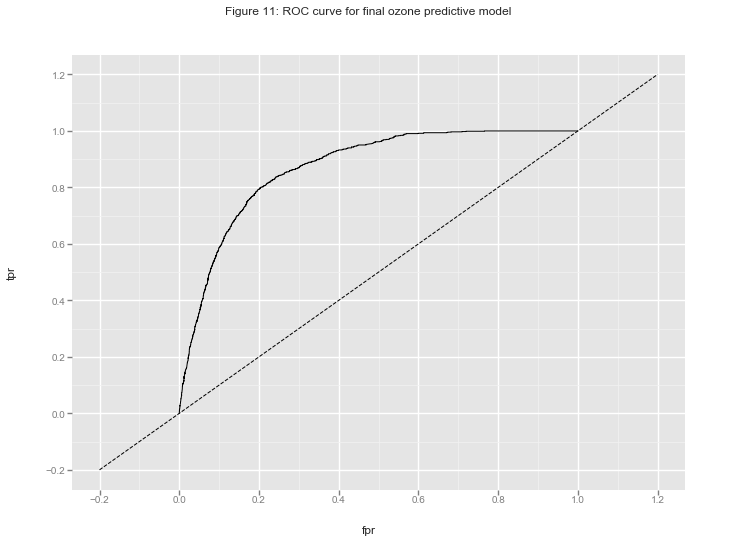

<ggplot: (-9223372036554702830)>

In [25]:
preds = lrcvb.predict_proba(X_test_oz)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test_oz, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed') +\
    ggtitle("Figure 11: ROC curve for final ozone predictive model")

In [26]:
# Fit the regression to the train set
lrcvb.fit(X_train_no, y_train_no)
# Predict the labels of the test set
y_pred_no = lrcvb.predict(X_test_no)

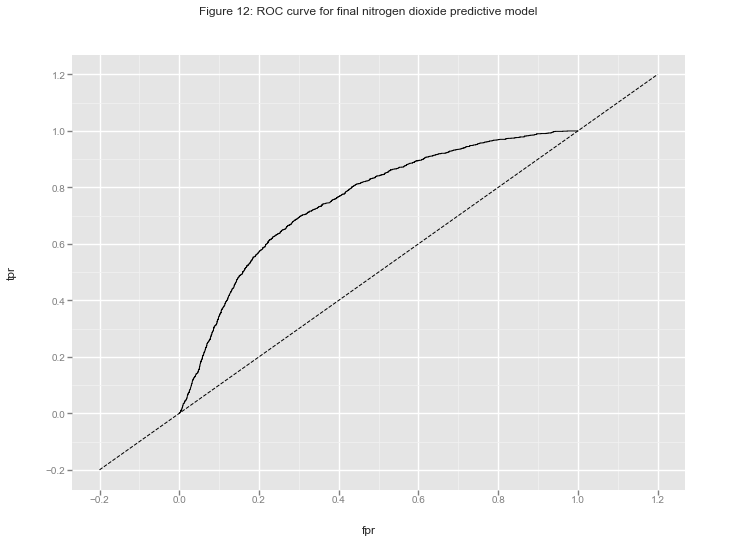

<ggplot: (302890935)>

In [27]:
preds = lrcvb.predict_proba(X_test_no)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test_no, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed') +\
    ggtitle("Figure 12: ROC curve for final nitrogen dioxide predictive model")

In [28]:
# Fit the regression to the train set
lrcvb.fit(X_train_so, y_train_so)
# Predict the labels of the test set
y_pred_no = lrcvb.predict(X_test_so)

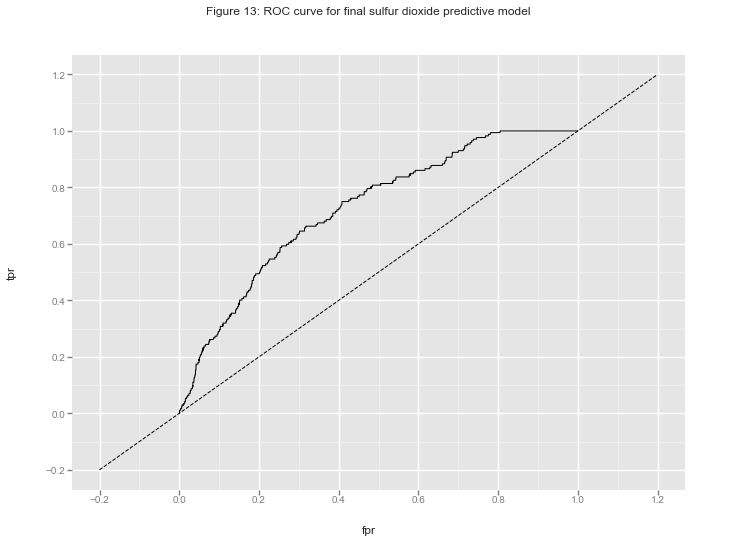

<ggplot: (-9223372036554594195)>

In [29]:
preds = lrcvb.predict_proba(X_test_so)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test_so, preds)

df = pd.DataFrame(dict(fpr=fpr, tpr=tpr))
ggplot(df, aes(x='fpr', y='tpr')) +\
    geom_line() +\
    geom_abline(linetype='dashed') +\
    ggtitle("Figure 13: ROC curve for final sulfur dioxide predictive model")

## Discussion

___
### Conclusions

Per the Environmental Protection Agency, nitrogen dioxide, carbon monoxide and sulfur dioxide are released into the air from burning of fossil fuels (such as operation of motor vehicles) and emissions from industrial plants; ozone is created when these and other air pollutants react in the presence of sunlight. Nitrogen dioxide, sulfur dioxide and ozone harmfully impact the human respiratory system while carbon monoxide affects the cardiovascular system.

The scientific literature strongly supports a relationship between elevated pollutant levels and increased hospitalizations, emergency department visits and mortality.  As one example, the figure below shows the number of emergency or urgent daily respiratory admissions to acute care hospitals as related to estimated ozone exposure (Burnett et al., 1994; U.S. EPA, 1996).


![Image](https://www.epa.gov/sites/production/files/2016-05/brtfig9-5.gif)

Certain features of the weather have been demonstrated here to predict pollution levels as normal/good versus elevated.  This could prove useful in managing at-risk populations during periods of elevated pollution levels.


___
### Client Recommendations

Based on the analysis presented, recommendations could be made to Kaiser Permanente in several areas:

* Prevention
    * Population Health Management
        * As Kaiser Permanente prides itself on proactive communication with patients for reminders and health advisories, the organization’s communications group should use pollutant forecasting to message members by region with recommendations for elevated pollutant days.  In line with EPA recommendations, this may include advisories to avoid time or exercise outside.  Given the links between air pollution and induction of new cases of respiratory disease, this is prudent even for the healthy as-yet-unaffected members of the population.
    * Management of high risk patients
        * For high-risk patients with known respiratory and cardiovascular diseases, or populations such as the elderly and infants, exposure to air pollution can trigger more serious episodes.  Therefore, communications based on the pollutant forecasting are even more critical with these patients.  
        * Depending on the severity of the pollutant levels, Kaiser Permanente should consider email and robocall messaging to provide information and recommended actions to patients already diagnosed with respiratory diseases, cardiovascular diseases, the elderly and the very young.
        * Kaiser Permanente should also consider using their existing online nurse practitioner and doctor visit system to reach out to their highest-risk patients to discuss any further medical recommendations, such as changes in medication or more aggressive case management.
* Staffing
    * Hospital and Emergency Room
        * The predictive modeling of pollutant levels shown here combined with the predicted increase in health service utilization from the literature could inform Kaiser Permanente staffing planning.  The addition of medical staff to outpatient clinics and emergency rooms on days with an expected increase in pollution-caused illness would allow improved management of the spike in visits and perhaps reduce hospital admissions if care could be provided sooner in an outpatient facility.
    * TeleHealth
        * Increased staffing of telehealth resources to communicate with patients by phone or the internet in periods of higher pollutant levels could allow management of some patients without utilization of in-person resources.

Taken together, these initiatives have the potential to increase cost savings while improving patient care.  One recent example ([American Journal of Accountable Care 2017](www.ajmc.com/journals/ajac/2017/2017-vol5-n3/population-health-in-primary-care-cost-quality-and-experience-impact) at Denver Health, a smaller managed care organization, evaluating the usage of population health strategies and predictive modeling to match resourcing with patient needs demonstrated $15.8 million savings over 26 months.  A larger organization such as Kaiser Permanente could yield significant savings through increased usage of predictive modeling to address patient health needs.


___
### Future Work

Two specific areas could help expand the utility of this analysis:

* Inclusion of emergency room visits and hospital admissions for respiratory diseases in order to better predict the actual increase in illness caused by pollutant levels.  Unfortunately, the only available data through free sources was monthly/annual rates of hospital/ER visits, which do not provide the granularity necessary to make accurate predictions.
* It would be interesting to evaluate weather data leading up to any given day and determine how influential that is on pollutant levels, including if a rolling 3-day average is a better predictor and how large the window of influence is.


___
### Code

All project code can be found in its Github repository [here](https://github.com/bouncebarkrun/Springboard-Data-Science-Career-Track/tree/master/1st Capstone Project).